# Torchify batch norm notebook

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

Starting from [here](https://www.youtube.com/watch?v=P6sfmUTpUmc&t=4715s).

- Linear Layer
  - n_inputs, n_outputs, bias-flag
  - pass is done in call method
  - parameters returns list
  - remember to scale weights


In [2]:
class Linear:
    def __init__(self, n_in, n_out, bias=True) -> None:
        self.W = torch.randn((n_in, n_out), requires_grad=True)
        self.W.data /= n_in**.5
        self.use_bias = bias
        if bias:
            self.b = torch.zeros((1,n_out), requires_grad=True)
        

    def __call__(self, x):
        self.out = x @ self.W
        if self.use_bias:
            self.out += self.b
        return self.out

    def parameters(self):
        if self.use_bias: return [self.W, self.b]
        return [self.W]

- BatchNorm1d
  - dim
  - eps (division by std)
  - momentum
  - training-flag to toggle running-mean calculation
  - keep track of var instead of std
  - in training:
    - use exact mean/std of batch, still update running statistics


In [85]:
class BatchNorm1d:
    def __init__(self, dim, train=True, momentum=.1, eps=1e-5):
        self.dim = dim
        self.train = train
        self.momentum = momentum
        self.eps = eps

        self.running_mean = torch.zeros(dim, requires_grad=False)
        self.running_var = torch.ones(dim, requires_grad=False)

        self.gain = torch.zeros(dim, requires_grad=True)
        self.scale = torch.ones(dim, requires_grad=True)

    def __call__(self, x: torch.Tensor):
        if self.train:
            batch_mean = x.mean(dim=0, keepdim=True)
            batch_var = x.var(dim=0, keepdim=True)
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var

        self.out = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        self.out = self.out * self.scale + self.gain

        if self.train:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*batch_mean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*batch_var

        return self.out

    def parameters(self):
        return [self.gain, self.scale]

- Tanh
  - simple


In [86]:
class Tanh:
    def __call__(self, x: torch.Tensor):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [87]:
class Embedding:
    def __init__(self, emb_size, n_in):
        self.emb_size = emb_size
        self.n_in = n_in
        self.C = torch.randn((n_in, emb_size), requires_grad=True)

    def __call__(self, x: torch.Tensor):
        self.out = self.C[x] # embed the characters into vectors
        self.out = self.out.view(self.out.shape[0], -1) # concatenate the vectors

        return self.out

    def parameters(self): return [self.C]

- In general:
  - use self.out to store output

- load data from files

In [88]:
from pathlib import Path


def load(filename):
    data = Path('../data/')
    return torch.load(data/filename)


x_train = load('x_train')
y_train = load('y_train')

- build 6 layer network
  - scale last layer weights down by .1
  - scale all other layers by 5/3

In [89]:
class Sequential:
    def __init__(self, layer_list):
        self.layer_list = layer_list

    def __call__(self, x):
        for layer in self.layer_list:
            x = layer(x)

        return x

    def parameters(self):
        return sum((layer.parameters() for layer in self.layer_list), start=[])

In [90]:
import torch.nn

emb_size = 10
n_hidden = 100
vocab_size = 27

net = Sequential([
    Embedding(emb_size, vocab_size),
    Linear(3*emb_size, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])
g = torch.Generator().manual_seed(2147483647) # for reproducibility

with torch.no_grad():
    net.layer_list[-1].W *= .1
    for layer in net.layer_list[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3


- training loop
  - embed
  - linear application of all layers
  - cross entropy
  - retain_graph on all layer.out

In [91]:
batch_size = 32
max_steps = 1
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    xb, yb = x_train[ix], y_train[ix] # batch X,Y

    x = net(xb)
    
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for layer in net.layer_list[1:]:
        layer.out.retain_grad()

    for p in net.parameters():
      p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in net.parameters():
      p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/      1: 3.3128


- visualization
  - for each layer, take out of tanh
    - mean, std, percent of >.97
  - plot histograms for each layer into one diagram

In [92]:
tanhs = [layer.out for layer in net.layer_list if isinstance(layer, Tanh)][:-1]

activations = [tanh.detach().numpy() for tanh in tanhs]
grads = [tanh.grad.detach().numpy() for tanh in tanhs]

Tanh #0 | mean=0.0015 | std=0.7200 | saturation=14.1562 %
Tanh #1 | mean=0.0123 | std=0.6908 | saturation=7.9062 %
Tanh #2 | mean=-0.0193 | std=0.6602 | saturation=5.8750 %
Tanh #3 | mean=0.0109 | std=0.6585 | saturation=5.9688 %


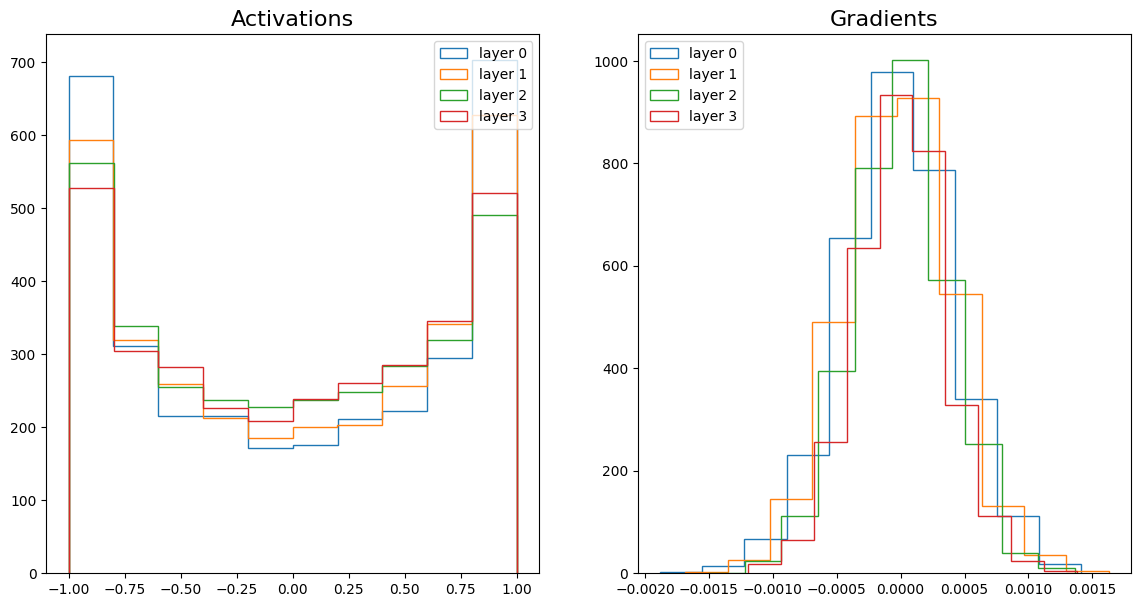

In [93]:
import numpy as np

fig, (l,r) = plt.subplots(ncols=2, figsize=(14,7))

for e,activation in enumerate(activations):
    l.hist(activation.flatten(), histtype="step", label=f'layer {e}')
    print(f'Tanh #{e} | mean={activation.mean():.4f} | std={activation.std():.4f} | saturation={(np.abs(activation)>.97).mean()*100:.4f} %')
l.set_title('Activations', fontsize=16)

for e,grad in enumerate(grads):
    r.hist(grad.flatten(), histtype="step", label=f'layer {e}')
r.set_title('Gradients', fontsize=16)

l.legend()
r.legend()
plt.show()

- same visualization for grads

- Add BatchNorm1d layers after all linear layers
  - also after last linear layer
  - scale that ones gain by .1

In [94]:
import torch.nn

emb_size = 10
n_hidden = 100
vocab_size = 27

net = Sequential([
    Embedding(emb_size, vocab_size),
    Linear(3*emb_size, n_hidden), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
])
net.layer_list[-1].gain.data *= .1
g = torch.Generator().manual_seed(2147483647) # for reproducibility

In [95]:
batch_size = 32
max_steps = 1000
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    xb, yb = x_train[ix], y_train[ix] # batch X,Y

    x = net(xb)
    
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for layer in net.layer_list[1:]:
        layer.out.retain_grad()

    for p in net.parameters():
      p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in net.parameters():
      p.data += -lr * p.grad

    # track stats
    if i % 100 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/   1000: 3.6565
    100/   1000: 2.6623
    200/   1000: 2.5012
    300/   1000: 2.3784
    400/   1000: 2.5127
    500/   1000: 2.7893
    600/   1000: 2.7251
    700/   1000: 2.3603
    800/   1000: 2.4786
    900/   1000: 2.3973


- Check the relative update size of the weights

In [102]:
import torch.nn

emb_size = 10
n_hidden = 100
vocab_size = 27

net = Sequential([
    Embedding(emb_size, vocab_size),
    Linear(3*emb_size, n_hidden, bias=False), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden, bias=False), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden, bias=False), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden, bias=False), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden, bias=False), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
])
net.layer_list[-1].gain.data *= .1
g = torch.Generator().manual_seed(2147483647) # for reproducibility

In [103]:
from collections import defaultdict
batch_size = 32
max_steps = 1000
lossi = []
updates = defaultdict(list)

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    xb, yb = x_train[ix], y_train[ix] # batch X,Y

    x = net(xb)
    
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for layer in net.layer_list[1:]:
        layer.out.retain_grad()

    for p in net.parameters():
      p.grad = None
    loss.backward()
    
    for e,layer in enumerate(net.layer_list):
      if isinstance(layer, Linear):
        p = layer.W
        update = (lr * p.grad).std()
        relative_update = update / p.data.std()
        updates[e].append(relative_update.log10().item())


    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in net.parameters():
        p.data += -lr * p.grad

    # track stats
    if i % 100 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/   1000: 3.8214
    100/   1000: 2.7013
    200/   1000: 2.6404
    300/   1000: 2.4258
    400/   1000: 2.4468
    500/   1000: 2.8686
    600/   1000: 2.7859
    700/   1000: 2.4253
    800/   1000: 2.5986
    900/   1000: 2.4320


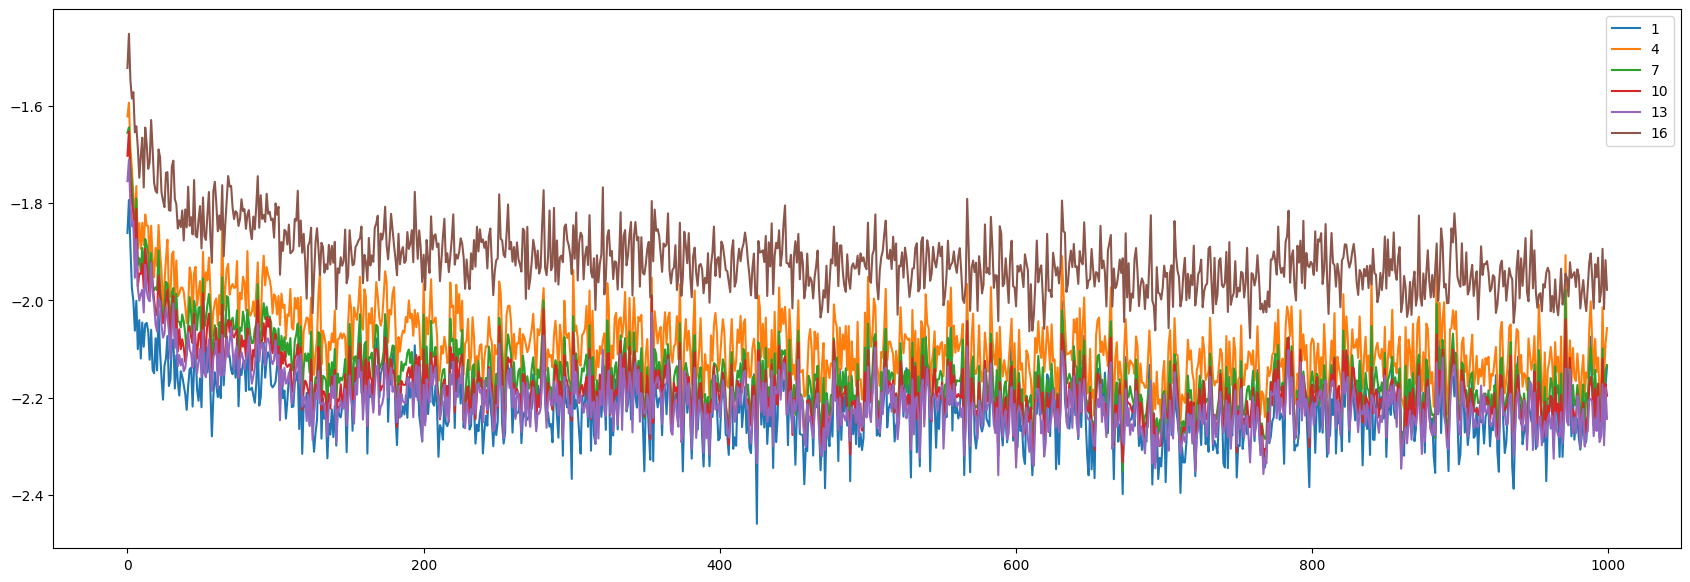

In [104]:
fig, ax = plt.subplots(figsize=(21,7))

for p_num, update in updates.items():
    ax.plot(update, label=p_num)

ax.legend()

plt.show()